!!!!!! TODO:

lalwaveform.lalsim_fd_waveform incorectly sets uses hp and hc in setting Waveform.from_hp_hc. The function should be renamed Waveform.from_real_imag, and you should input ~hp + i*~hc. You are sort of doing this, but make sure it's correct.

Also you are inputing ~hp + i~hc as the data ~h instead of Fphp + Fc*hc. This is why your amplitude is too large.

!!!!!!


In [1]:
# The term you are looking for to find the best choice of parameters when you have data values:
# sepervised dimensionality reduction

#shift-tab on a function gets its docstring

%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [52]:
np.set_printoptions(precision=4, linewidth=150)

In [2]:
import lal
import lalsimulation

import pycbc.filter
#import pycbc.waveform
import pycbc.types
import pycbc.psd

In [3]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [26]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import fisher

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(fisher)

import constants
imp.reload(constants)
from constants import *

# Functions for constructing surrogate

In [5]:
def geometric_waveform_to_physical_hp_hc(h_geom, mtot, distance, inclination, f_min, f_max, delta_f):
    """Convert a frequency-domain Waveform object to ~h_+ and ~h_x in physical units (Hz^{-1})
    using the same convention as lalsimulation:
        -Uniformly spaced frequencies in [0, f_max).
        -Data is zero below max(f_min, first data point in h_geom) and
        zero above min(f_max, last data point in h_geom).
    """
    h_phys = wave.dimensionless_to_physical_freq(h_geom, mtot, distance)
    
    # Initialize arrays. The output is zero below f_min.
    freq = np.arange(0.0, f_max, delta_f)
    h_plus = np.zeros(len(freq), dtype=complex)
    h_cross = np.zeros(len(freq), dtype=complex)
    
    # Find the nonzero elements
    f_min_nonzero = max(f_min, h_phys.x[0])
    f_max_nonzero = min(f_max, h_phys.x[-1])
    # Can't compare arrays with 'and'. Have to use bitwise '&' instead.
    i_nonzero = np.where((freq>=f_min_nonzero) & (freq<=f_max_nonzero))
    freq_nonzero = freq[i_nonzero]
    
    # Amplitude and phase in the nonzero region
    amp = h_phys.interpolate('amp')(freq_nonzero)
    phase = h_phys.interpolate('phase')(freq_nonzero)
    
    inc_plus = 0.5*(1.0+np.cos(inclination)**2)
    inc_cross = np.cos(inclination)
    
    h_plus[i_nonzero] = inc_plus * 0.5*amp*np.exp(1.0j*phase)
    h_cross[i_nonzero] = inc_cross * 0.5*amp*np.exp(1.0j*(phase+np.pi/2.0))
    
    return freq, h_plus, h_cross

In [6]:
def physical_to_pycbc_frequency_series(freq, h_plus, h_cross):
    """Convert numpy arrays to pycbc frequency series.
    """
    delta_f = freq[1]-freq[0]
    hp_fs = pycbc.types.FrequencySeries(h_plus, delta_f=delta_f)
    hc_fs = pycbc.types.FrequencySeries(h_cross, delta_f=delta_f)
    return hp_fs, hc_fs

In [97]:
class GPSurrogate(object):
    def __init__(self, Bamp, Bphase, damp_gp_list, dphase_gp_list):
        self.Bamp = Bamp
        self.Bphase = Bphase
        self.damp_gp_list = damp_gp_list
        self.dphase_gp_list = dphase_gp_list
        
        self.mf_start = self.Bamp[0].x[0]
        self.mf_end = self.Bamp[0].x[-1]
        
    @classmethod
    def load(cls, Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename):
        Bamp = ws.HDF5WaveformSet(Bamp_filename)
        Bphase = ws.HDF5WaveformSet(Bphase_filename)
        damp_gp_list = gpr.load_gaussian_process_regression_list(damp_gp_filename)
        dphase_gp_list = gpr.load_gaussian_process_regression_list(dphase_gp_filename)
        return GPSurrogate(Bamp, Bphase, damp_gp_list, dphase_gp_list)
    
    def geometric_reference_waveform(self, params):
        # !!!!!!!! The hardcoded delta_mf is only temporary.
        # The final version will use your own functions for the 
        # amplitude and phase of TaylorF2 evaluated at the
        # same frequencies as h_diff_sur. !!!!!!!!!
        # Is it possible to get the functions that create the amplitude and phase?
        q, s1, s2, lambda1, lambda2 = params
        delta_mf = 1.0e-8
        h_ref = lalwaveform.dimensionless_fd_waveform(approximant='TaylorF2', 
                                  q=q, spin1z=s1, spin2z=s2, 
                                  lambda1=lambda1, lambda2=lambda2, 
                                  mf_min=self.mf_start, mf_max=self.mf_end, delta_mf=delta_mf)
        # Reference waveform has zero starting phase
        h_ref.add_phase(remove_start_phase=True)
        return h_ref
    
    def amp_phase_difference(self, params):
        return surrogate.reconstruct_amp_phase_difference(params, self.Bamp, self.Bphase, 
                                                          self.damp_gp_list, self.dphase_gp_list)
    
    def geometric_waveform(self, params):
        # Surrogate of \Delta\Phi and \Delta\ln A
        h_diff_sur = self.amp_phase_difference(params)
        
        # Reference waveform
        h_ref = self.geometric_reference_waveform(params)
        
        # Surrogate of A and \Phi
        h_sur = h_ref.copy()
        h_sur.resample(h_diff_sur.x)
        h_sur.amp *= np.exp(h_diff_sur.amp)
        h_sur.phase += h_diff_sur.phase
        return h_sur
    
    def __call__(self, params):
        """Simpler way of calling self.geometric_waveform(params).
        """
        return self.geometric_waveform(params)
    
    def physical_waveform(self, mass1=None, mass2=None, 
                          spin1z=None, spin2z=None, 
                          lambda1=None, lambda2=None,
                          delta_f=None, f_min=None, f_max=None, f_ref=None, 
                          distance=None, inclination=None, phi_ref=None):
        """Construct pycbc FrequencySeries of ~hp and ~hc with physical units.
        """
        #TODO: phi_ref is the phase at f_ref. These are not currently set.
        
        ################ Check for correct input ################
        #if f_lower < 100.0 or f_lower>700.0: raise ValueError('f_lower must be in range [100, 700]Hz')
        if spin1z < -0.7 or spin1z > 0.7 or spin2z < -0.7 or spin2z > 0.7:
            raise ValueError('Valid spins: spin1z in [-0.7, 0.7], spin2z in [-0.7, 0.7]')
        if lambda1 < 0 or lambda1 > 10000 or lambda2 < 0 or lambda2 > 10000:
            raise ValueError('Valid tidal parameter range: lambda1 in [0, 10000], lambda2 in [0, 10000]')
        
        # If mass1 is not the larger mass, swap (mass1, mass2), (spin1z, spin2z), and (lambda1, lambda2)
        if mass1 < mass2:
            mass1, mass2 = mass2, mass1
            spin1z, spin2z = spin2z, spin1z
            lambda1, lambda2 = lambda2, lambda1
        
        if mass2 < 1.0:
            raise ValueError('Mass of less massive star must be >= 1M_sun.')
            
        q = mass2/mass1
        if q < 1.0/3.0 or q > 1.0:
            raise ValueError('Valid mass ratio range: q in [1/3, 1].')
        
        ########## Construct resampled waveform with physical units #########
        mtot = mass1 + mass2
        params = np.array([q, spin1z, spin2z, lambda1, lambda2])
        h_geom = self.geometric_waveform(params)
        
        freq, h_plus, h_cross = geometric_waveform_to_physical_hp_hc(h_geom, mtot, distance, inclination, 
                                                                     f_min, f_max, delta_f)
        #return freq, h_plus, h_cross
        hp_fs, hc_fs = physical_to_pycbc_frequency_series(freq, h_plus, h_cross)
        return hp_fs, hc_fs

# Diagnostics

In [79]:
def lalsim_fd_waveform_arrays(long_asc_nodes=0.0, eccentricity=0.0, mean_per_ano=0.0,
                       phi_ref=0.0, f_ref=None,
                       phase_order=-1, amplitude_order=-1, spin_order=-1, tidal_order=-1, **p):
    """Wrapper for lalsimulation.SimInspiralChooseTDWaveform.
    Simplified version of pycbc.waveform.get_td_waveform wrapper.
    
    Parameters
    ----------
    f_ref : Reference frequency (?For setting phi_ref? Not sure.) Defaults to f_min.
    phi_ref : Reference phase (?at f_ref?).
    
    Returns
    -------
    h : Waveform
    """
    if f_ref==None:
        f_ref = p['f_min']
        
    # Set extra arguments in the lal Dict structure
    lal_pars = lal.CreateDict()
    if phase_order!=-1:
        lalsimulation.SimInspiralWaveformParamsInsertPNPhaseOrder(lal_pars, int(phase_order))
    if amplitude_order!=-1:
        lalsimulation.SimInspiralWaveformParamsInsertPNAmplitudeOrder(lal_pars, int(amplitude_order))
    if spin_order!=-1:
        lalsimulation.SimInspiralWaveformParamsInsertPNSpinOrder(lal_pars, int(spin_order))
    if tidal_order!=-1:
        lalsimulation.SimInspiralWaveformParamsInsertPNTidalOrder(lal_pars, int(tidal_order))
    if p['lambda1']:
        lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(lal_pars, p['lambda1'])
    if p['lambda2']:
        lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(lal_pars, p['lambda2'])
    
    # Set Approximant (C enum structure) corresponding to approximant string
    lal_approx = lalsimulation.GetApproximantFromString(p['approximant'])
    
    hp, hc = lalsimulation.SimInspiralChooseFDWaveform(
        float(MSUN_SI*p['mass1']),
        float(MSUN_SI*p['mass2']),
        float(p['spin1x']), float(p['spin1y']), float(p['spin1z']),
        float(p['spin2x']), float(p['spin2y']), float(p['spin2z']),
        float(MPC_SI*p['distance']), float(p['inclination']), 
        float(phi_ref),
        float(long_asc_nodes), float(eccentricity), float(mean_per_ano),
        float(p['delta_f']), float(p['f_min']), float(p['f_max']), float(f_ref),
        lal_pars, lal_approx)
    
    #return hp, hc
    # Extract data from lalsimulation's structures
    # The first data point in hp.data.data corresponds to f=0 not f=f_min
    # TODO: Should you just truncate data below f_min here? Not sure.
    freq = hp.deltaF*np.arange(hp.data.length)
    return freq, hp.data.data, hc.data.data

In [80]:
def lalsim_waveform_time_series(long_asc_nodes=0.0, eccentricity=0.0, mean_per_ano=0.0,
                       phi_ref=0.0, f_ref=None,
                       phase_order=-1, amplitude_order=-1, spin_order=-1, tidal_order=-1, **p):
    """Wrapper for lalsimulation.SimInspiralChooseTDWaveform.
    Simplified version of pycbc.waveform.get_td_waveform wrapper.
    
    Parameters
    ----------
    f_ref : Reference frequency (?For setting phi_ref? Not sure.) Defaults to f_min.
    phi_ref : Reference phase (?at f_ref?).
    
    Returns
    -------
    h : Waveform
    """
    if f_ref==None:
        f_ref = p['f_min']
        
    # Set extra arguments in the lal Dict structure
    lal_pars = lal.CreateDict()
    if phase_order!=-1:
        lalsimulation.SimInspiralWaveformParamsInsertPNPhaseOrder(lal_pars, int(phase_order))
    if amplitude_order!=-1:
        lalsimulation.SimInspiralWaveformParamsInsertPNAmplitudeOrder(lal_pars, int(amplitude_order))
    if spin_order!=-1:
        lalsimulation.SimInspiralWaveformParamsInsertPNSpinOrder(lal_pars, int(spin_order))
    if tidal_order!=-1:
        lalsimulation.SimInspiralWaveformParamsInsertPNTidalOrder(lal_pars, int(tidal_order))
    if p['lambda1']:
        lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(lal_pars, p['lambda1'])
    if p['lambda2']:
        lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(lal_pars, p['lambda2'])
    
    
    # Set Approximant (C enum structure) corresponding to approximant string
    lal_approx = lalsimulation.GetApproximantFromString(p['approximant'])
    
    hp, hc = lalsimulation.SimInspiralChooseTDWaveform(
        float(MSUN_SI*p['mass1']),
        float(MSUN_SI*p['mass2']),
        float(p['spin1x']), float(p['spin1y']), float(p['spin1z']),
        float(p['spin2x']), float(p['spin2y']), float(p['spin2z']),
        float(MPC_SI*p['distance']), float(p['inclination']), 
        float(phi_ref),
        float(long_asc_nodes), float(eccentricity), float(mean_per_ano),
        float(p['delta_t']), float(p['f_min']), float(f_ref),
        lal_pars, lal_approx)
    
    # Extract data from lalsimulation's structures
    tstart = hp.epoch.gpsSeconds+hp.epoch.gpsNanoSeconds*1.0e-9
    hpTS = pycbc.types.TimeSeries(hp.data.data, delta_t=hp.deltaT, epoch=tstart)
    hcTS = pycbc.types.TimeSeries(hc.data.data, delta_t=hc.deltaT, epoch=tstart)
    
    return hpTS, hcTS

In [81]:
def mismatch(h1, h2, f_min):
    """
    """
    flen = len(h1)
    delta_f = h1.delta_f
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_min)
    
    # Mismatch
    return 1.0-pycbc.filter.match(h1, h2, psd=psd, low_frequency_cutoff=f_min)[0]

# Compare surrogate to original waveform in geometric units

In [98]:
Bamp_filename = '../data/Bamp.hdf5'
Bphase_filename = '../data/Bphase.hdf5'
damp_gp_filename = '../data/amp_gp.hdf5'
dphase_gp_filename = '../data/phase_gp.hdf5'
sur = GPSurrogate.load(Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename)

In [99]:
trainset = ws.HDF5WaveformSet('../data/h_training_set.hdf5')
testset_rand = ws.HDF5WaveformSet('../data/h_test_set_rand.hdf5')
testset_uni = ws.HDF5WaveformSet('../data/h_test_set_uniform.hdf5')

[  3.4397e-01   6.3434e-01   3.9719e-01   1.9338e+03   4.2085e+03]


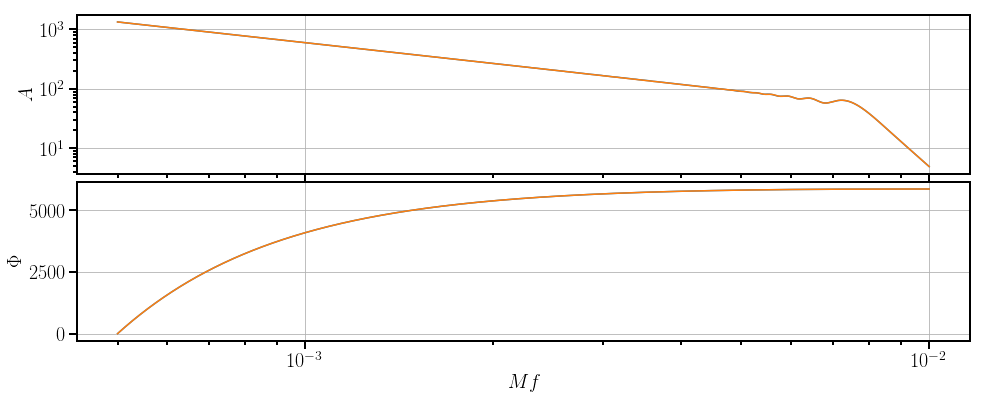

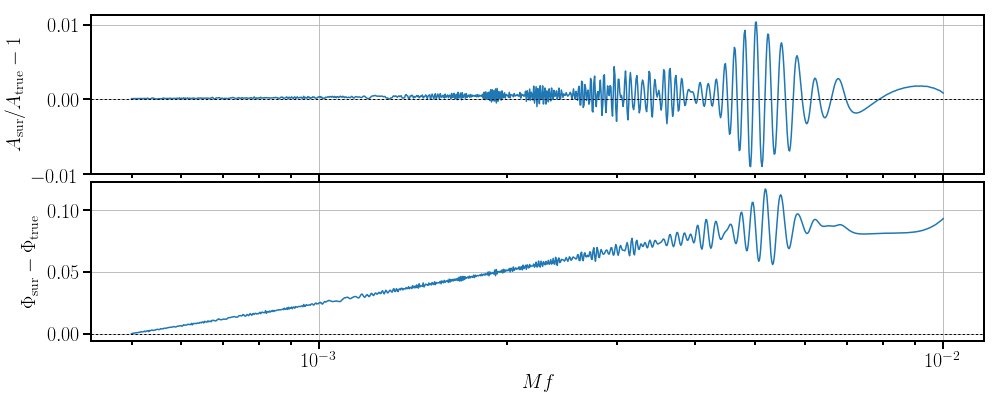

In [100]:
i = 999
#h_true = trainset[i]
#params = trainset.get_waveform(i, data='parameters')
h_true = testset_rand[i]
params = testset_rand.get_waveform(i, data='parameters')
print params
h_sur = sur(params)

# Plot h_true and h_sur
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_sur, h_true])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Plot error
fig, (ax1, ax2) = wave.plot_waveform_difference_fd(h_sur, h_true, xi=None, xf=None, npoints=1000)
ax1.set_ylabel(r'$A_{\rm sur}/A_{\rm true} - 1$')
ax2.set_ylabel(r'$\Phi_{\rm sur} - \Phi_{\rm true}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Convert waveforms to physical units for $\tilde h_+$ and $\tilde h_\times$

In [14]:
# Test set (true) waveform
i = 999
h_true = testset_rand[i]
params = testset_rand.get_waveform(i, data='parameters')

q, spin1z, spin2z, lambda1, lambda2 = params
mass2 = 1.1
mass1 = mass2/q
f_min = 40.
f_max = 4096.
f_ref = 40.
phi_ref = 0.
distance = 100.
inclination = 1.2

mtot = mass1+mass2
f, hp, hc = geometric_waveform_to_physical_hp_hc(
    h_true, mtot, distance, inclination, f_min, f_max, delta_f)
hp_true_phys, hc_true_phys = physical_to_pycbc_frequency_series(f, hp, hc)

# Surrogate waveform
hp_sur_phys, hc_sur_phys = sur.physical_waveform(
    mass1=mass1, mass2=mass2, 
    spin1z=spin1z, spin2z=spin2z, 
    lambda1=lambda1, lambda2=lambda2,
    delta_f=delta_f, f_min=f_min, f_max=f_max, f_ref=f_ref, 
    distance=distance, inclination=inclination, phi_ref=phi_ref)

NameError: name 'delta_f' is not defined

In [240]:
# Convert pycbc frequency series for ~h_+ to Waveform format
hp_sur = wave.Waveform.from_hp_hc(
    np.array(hp_sur_phys.sample_frequencies), np.array(hp_sur_phys).real, np.array(hp_sur_phys).imag)
hp_true = wave.Waveform.from_hp_hc(
    np.array(hp_true_phys.sample_frequencies), np.array(hp_true_phys).real, np.array(hp_true_phys).imag)

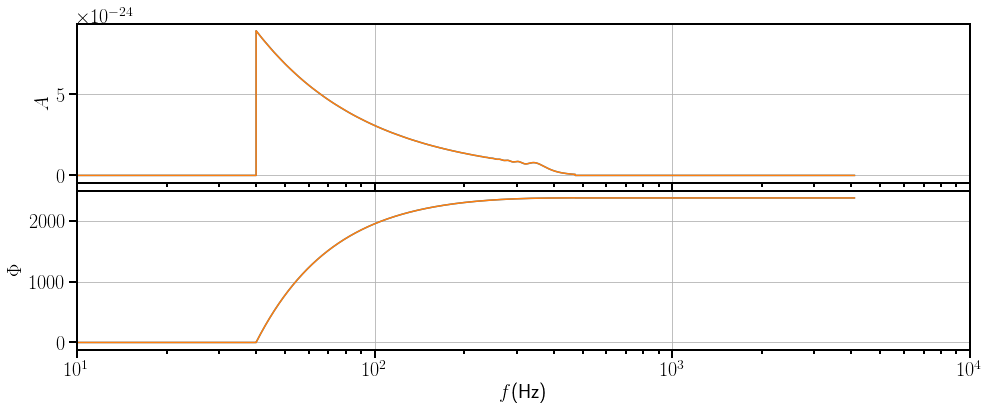

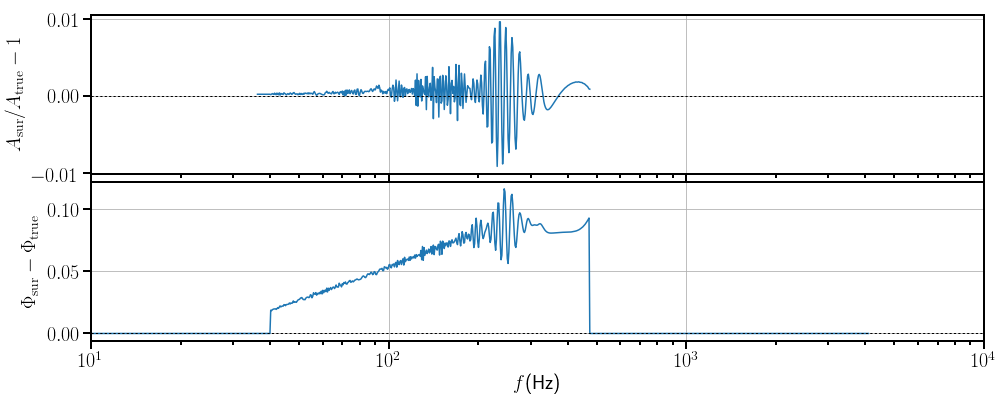

In [241]:
# Plot h_true and h_sur
fig, (ax1, ax2) = wave.plot_waveforms_fd([hp_sur, hp_true])
#ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$f$(Hz)')
ax2.set_xlim(10, 10000)
ax1.grid()
ax2.grid()

# Plot error
fig, (ax1, ax2) = wave.plot_waveform_difference_fd(hp_sur, hp_true, xi=10, npoints=1000)
ax1.set_ylabel(r'$A_{\rm sur}/A_{\rm true} - 1$')
ax2.set_ylabel(r'$\Phi_{\rm sur} - \Phi_{\rm true}$')
ax2.set_xlabel(r'$f$(Hz)')
ax2.set_xlim(10, 10000)
ax1.grid()
ax2.grid()

In [254]:
# The delta_f of the T4 waveform is not quite the same as the surrogate. This will throw an error
print mismatch(hp_sur_phys, hp_true_phys, f_min)
print mismatch(hc_sur_phys, hc_true_phys, f_min)

0.000213270873107
0.000213270873107


# Compute mismatches for all waveforms in test set

In [273]:
def surrogate_mismatch(i, f_min, f_max, delta_f=0.01, mass2=1.0, distance=100., inclination=1.2):
    """
    """
    
    h_true = testset_rand[i]
    params = testset_rand.get_waveform(i, data='parameters')
    
    q, spin1z, spin2z, lambda1, lambda2 = params
    mass1 = mass2/q
    f_ref = f_min
    phi_ref = 0.

    print mass1, mass2, spin1z, spin2z, lambda1, lambda2
    # Generate true waveform in physical units from testset waveform
    mtot = mass1+mass2
    f, hp, hc = geometric_waveform_to_physical_hp_hc(
        h_true, mtot, distance, inclination, f_min, f_max, delta_f)
    hp_true_phys, hc_true_phys = physical_to_pycbc_frequency_series(f, hp, hc)
    
    # Generate surrogate waveform
    hp_sur_phys, hc_sur_phys = sur.physical_waveform(
        mass1=mass1, mass2=mass2, 
        spin1z=spin1z, spin2z=spin2z, 
        lambda1=lambda1, lambda2=lambda2,
        delta_f=delta_f, f_min=f_min, f_max=f_max, f_ref=f_ref, 
        distance=distance, inclination=inclination, phi_ref=phi_ref)
    
    return params, mismatch(hp_true_phys, hp_sur_phys, f_min)    

In [266]:
f_min = 40
f_max = 4096
mass2 = 1.0

params_list_10 = []
mismatch_list_10 = []
#for i in range(ts_rand.get_len()):
for i in range(100):
    print i,
    params, mm = surrogate_mismatch(i, f_min, f_max, delta_f=0.01, mass2=mass2, distance=100., inclination=1.2)
    params_list_10.append(params)
    mismatch_list_10.append(mm)
    
params_mm_10 = np.concatenate((np.array(params_list_10).T, np.array([mismatch_list_10]))).T
#np.savetxt('params_mm_10.txt', params_mm_10)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99


In [271]:
f_min = 40
f_max = 4096
mass2 = 2.0

params_list_20 = []
mismatch_list_20 = []
#for i in range(ts_rand.get_len()):
for i in range(100):
    print i,
    params, mm = surrogate_mismatch(i, f_min, f_max, delta_f=0.01, mass2=mass2, distance=100., inclination=1.2)
    params_list_20.append(params)
    mismatch_list_20.append(mm)
    
params_mm_20 = np.concatenate((np.array(params_list_20).T, np.array([mismatch_list_20]))).T
#np.savetxt('params_mm_20.txt', params_mm_20)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99


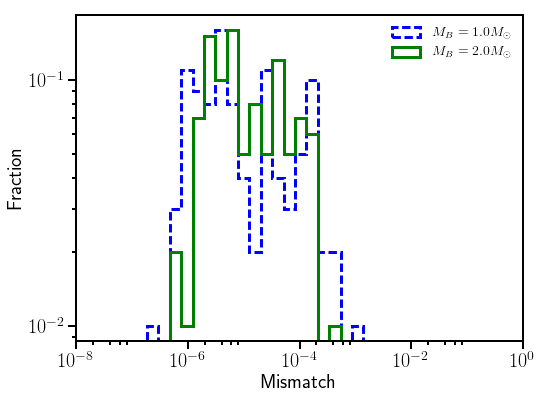

In [272]:
fig, axes = plt.subplots(1, figsize=(8, 6))

Nsamp = len(params_mm_10)
axes.hist(params_mm_10[:, 5], bins=np.logspace(-10, 0, 50), weights=np.ones(Nsamp)/Nsamp, histtype='step', 
          ls='--', lw=3, color='blue', alpha=1.0, label=r'$M_B=1.0M_\odot$')

Nsamp = len(params_mm_20)
axes.hist(params_mm_20[:, 5], bins=np.logspace(-10, 0, 50), weights=np.ones(Nsamp)/Nsamp, histtype='step', 
          ls='-', lw=3, color='green', alpha=1.0, label=r'$M_B=2.0M_\odot$')

axes.set_xscale("log")
axes.set_yscale("log")
axes.set_xlim([1.0e-8, 1.0e-0])
#axes.set_ylim([1, 1.0e8])
axes.set_xlabel(r'Mismatch')
axes.set_ylabel(r'Fraction')
axes.legend(loc='upper right', frameon=False)
#fig.savefig('/home/bdlackey/public_html/ROM/mismatchhist.pdf', format='pdf', transparent=True, bbox_inches='tight')

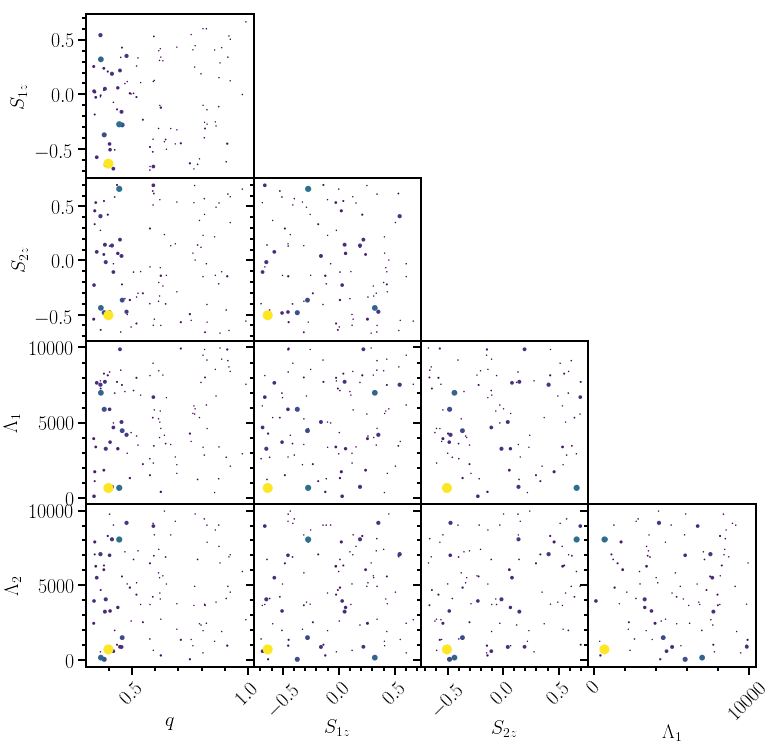

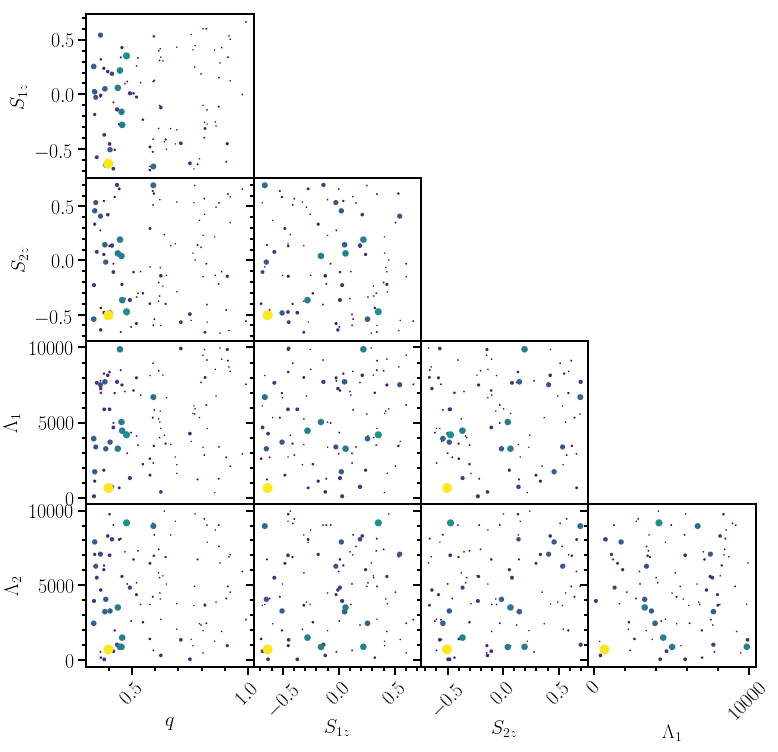

In [282]:
labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\Lambda_1$', r'$\Lambda_2$']

params = params_list_10
error = mismatch_list_10
#print len(error[error>=0.1])
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=None, figsize=(10, 10))

params = params_list_20
error = mismatch_list_20
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=None, figsize=(10, 10))

# Systematic error calculation

In [90]:
def surrogate_fisher_params(params, f_min, f_max, delta_f=1.0e-3, npoints=1000):
    """Wrapper for TaylorF2 with Fisher-matrix parameters.
    phase_order=4 corresponds to 2PN order.
    """
    lndist, f0tc, phic, lnmc, lneta, ssym, santi, tlambda, dtlambda = params
    
    distance = np.exp(lndist)
    mc = np.exp(lnmc)
    eta = np.exp(lneta)
    
    mass1 = fisher.m1_of_mchirp_eta(mc, eta)
    mass2 = fisher.m2_of_mchirp_eta(mc, eta)
    spin1z, spin2z = fisher.s1_s2_of_pe_params(ssym, santi)
    lambda1, lambda2 = fisher.lam1_lam2_of_pe_params(eta, tlambda, dtlambda)
    
    print distance, f0tc, phic, mass1, mass2, spin1z, spin2z, lambda1, lambda2
    
    inclination = 0.0
    
    hp_pycbc, hc_pycbc = sur.physical_waveform(
        mass1=mass1, mass2=mass2, 
        spin1z=spin1z, spin2z=spin2z, 
        lambda1=lambda1, lambda2=lambda2,
        delta_f=delta_f, f_min=f_min, f_max=f_max, f_ref=None, 
        distance=distance, inclination=inclination, phi_ref=None)
    
    h = wave.Waveform.from_complex(np.array(hp_pycbc.sample_frequencies), np.array(hp_pycbc))

    # Resample waveform
    fs = np.logspace(np.log10(f_min), np.log10(f_max), npoints)
    h.resample(fs)
    
    # Set the phase at the last data point to phic
    h.phase += phic - h.phase[-1]
    
    # Shift the coalescence time by f0tc (add 2 \pi f f0tc to Fourier transformed phase)
    h.phase += 2.*np.pi*h.x*f0tc
    
    # You might want to log-space resample the waveform if things become too slow,
    # but you will still have to sample the waveform finely enough to get the unwrapped
    # phase, so it might not help things that much anyway.
    return h

In [108]:
# Test set (true) waveform
i = 0

q, spin1z, spin2z, lambda1, lambda2 = testset_rand.get_waveform(i, data='parameters')
mass2 = 1.4
mass1 = mass2/q
mtot = mass1 + mass2
#mass1 = 1.4
#mass2 = 1.4
#spin1z = 0.1
#spin2z = 0.1
#lambda1 = 1000.
#lambda2 = 1000.
distance = 100.
inclination = 0
f_min = 1.05*mf_to_f(sur.mf_start, mtot)
f_max = 0.95*mf_to_f(sur.mf_end, mtot)

print q, mass1, mass2, spin1z, spin2z, lambda1, lambda2
print f_min, f_max

mchirp = fisher.mchirp_of_m1_m2(mass1, mass2)
eta = fisher.eta_of_m1_m2(mass1, mass2)

# The final Fisher matrix parameters
lndist = np.log(distance)
f0tc = 0.0
phic = 0.0
lnmc = np.log(mchirp)
lneta = np.log(eta)
ssym = fisher.ssym_of_s1_s2(spin1z, spin2z)
santi = fisher.santisym_of_s1_s2(spin1z, spin2z)
tlambda = fisher.lamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)
dtlambda = fisher.deltalamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)
params = (lndist, f0tc, phic, lnmc, lneta, ssym, santi, tlambda, dtlambda)
print params

# The file is actually an ASD not a PSD
psd_array = np.loadtxt('/Users/lackey/Research/NoiseCurves/LIGO/ZERO_DET_high_P.txt') 
psd_array[:, 1] = psd_array[:, 1]**2

fisher_sur = fisher.NumericalFisher(surrogate_fisher_params, params, f_min, f_max, psd_array)

# # Should return the error you gave
# params_exact = (lndist, f0tc, phic, lnmc, lneta, ssym, santi, tlambda+10, dtlambda)
# h_exact = surrogate_fisher_params(params_exact, f_min, f_max)

h_exact_geom = testset_rand[i]
delta_f = 1.0e-3
freq, h_plus, h_cross = geometric_waveform_to_physical_hp_hc(
    h_exact_geom, mtot, distance, inclination, f_min, f_max, delta_f)
hp_fs, hc_fs = physical_to_pycbc_frequency_series(freq, h_plus, h_cross)
h_exact = wave.Waveform.from_complex(freq, h_plus)

print 'SNR:', fisher_sur.snr()

0.452464400357 3.09416608002 1.4 0.33847366141 -0.660143196208 8494.08115839 8120.69977415
23.7170491585 429.16565144
(4.6051701859880918, 0.0, 0.0, 0.57903837344962006, -1.5395695926274939, -0.16083476739935076, 0.49930842880896298, 11204.878179176329, -2727.5340079771527)
SNR: 100.0 0.0 0.0 3.09416608002 1.4 0.33847366141 -0.660143196208 8494.08115839 8120.69977415
46.488550921


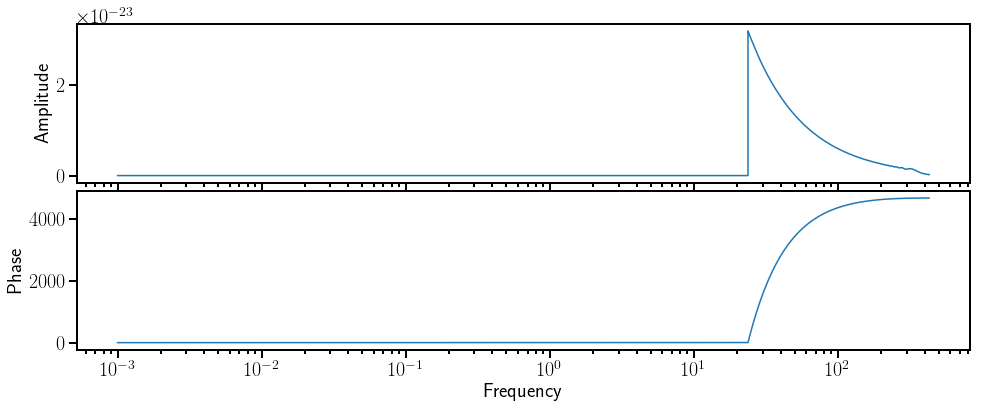

In [109]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_exact])

In [110]:
param_indices = [1, 2, 3, 4, 5, 6, 7]
dthetas = [0, 0.001, 0.1, 0.001, 0.0001, 0.001, 0.001, 10.0, 0]
dtypes = ['central', 'central', 'central', 'backward', 'central', 'central', 'forward']
prior_sigmas = [None, None, None, None, 0.1, 0.1, None]

# param_indices = [1, 2, 3, 4, 5]
# dthetas = [0, 0.001, 0.1, 0.001, 0.0001, 0.01, 0, 0, 0]
# dtypes = ['central', 'central', 'central', 'backward', 'central']
# #prior_sigmas = [None, None, None, None, 0.7]
# prior_sigmas = [None, None, None, None, None]

print 'SNR:', fisher_sur.snr()

fisher_sur.derivative_list_eval(param_indices, dthetas, dtypes)

gamma = fisher_sur.fisher_matrix()
print 'Gamma:'
print gamma
fisher_sur.prior_matrix(prior_sigmas)
print 'Prior inverse covariance:'
print fisher_sur.prior
cov = fisher_sur.covariance_matrix()
print 'Covariance:'
print cov
print 'Statistical error:'
stat_err = fisher_sur.get_sigmas()
print stat_err
print 'Correlation:'
corr = fisher_sur.get_correlation_matrix()
print corr
sys_err = fisher_sur.systematic_error(h_exact)
print 'Systematic error:'
print sys_err

print 'Sys/Stat error'
print sys_err/stat_err

stat_uncorr_err = fisher_sur.fisher.diagonal()**(-0.5)
stat_err / stat_uncorr_err

SNR: 100.0 0.0 0.0 3.09416608002 1.4 0.33847366141 -0.660143196208 8494.08115839 8120.69977415
46.488550921
100.0 -0.0005 0.0 3.09416608002 1.4 0.33847366141 -0.660143196208 8494.08115839 8120.69977415
100.0 0.0005 0.0 3.09416608002 1.4 0.33847366141 -0.660143196208 8494.08115839 8120.69977415
100.0 0.0 -0.05 3.09416608002 1.4 0.33847366141 -0.660143196208 8494.08115839 8120.69977415
100.0 0.0 0.05 3.09416608002 1.4 0.33847366141 -0.660143196208 8494.08115839 8120.69977415
100.0 0.0 0.0 3.09261938369 1.39930017497 0.33847366141 -0.660143196208 8494.08115839 8120.69977415
100.0 0.0 0.0 3.0957135499 1.40070017503 0.33847366141 -0.660143196208 8494.08115839 8120.69977415
100.0 0.0 0.0 3.09460739067 1.3998283474 0.33847366141 -0.660143196208 8493.02842252 8119.21750181
100.0 0.0 0.0 3.09416608002 1.4 0.33847366141 -0.660143196208 8494.08115839 8120.69977415
100.0 0.0 0.0 3.09416608002 1.4 0.33797366141 -0.660643196208 8494.08115839 8120.69977415
100.0 0.0 0.0 3.09416608002 1.4 0.3389736614

array([  17.7757,   56.7773,   19.6197,   35.9411,  172.7064,  166.3006,   65.8837])

[(<matplotlib.figure.Figure at 0x11507df10>,
  (<matplotlib.axes._subplots.AxesSubplot at 0x1151a3650>,
   <matplotlib.axes._subplots.AxesSubplot at 0x10920d850>)),
 (<matplotlib.figure.Figure at 0x11799f810>,
  (<matplotlib.axes._subplots.AxesSubplot at 0x11518ca10>,
   <matplotlib.axes._subplots.AxesSubplot at 0x1179d66d0>)),
 (<matplotlib.figure.Figure at 0x109322ad0>,
  (<matplotlib.axes._subplots.AxesSubplot at 0x11779fbd0>,
   <matplotlib.axes._subplots.AxesSubplot at 0x114067750>)),
 (<matplotlib.figure.Figure at 0x116875a90>,
  (<matplotlib.axes._subplots.AxesSubplot at 0x11655a410>,
   <matplotlib.axes._subplots.AxesSubplot at 0x1168043d0>)),
 (<matplotlib.figure.Figure at 0x115fd9bd0>,
  (<matplotlib.axes._subplots.AxesSubplot at 0x10886d210>,
   <matplotlib.axes._subplots.AxesSubplot at 0x11515b1d0>)),
 (<matplotlib.figure.Figure at 0x1154a4c50>,
  (<matplotlib.axes._subplots.AxesSubplot at 0x10a724f10>,
   <matplotlib.axes._subplots.AxesSubplot at 0x10b406090>)),
 (<matplot

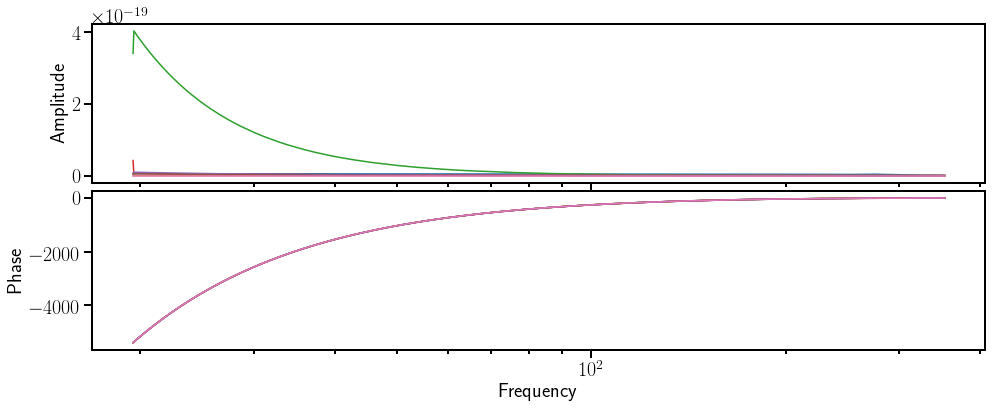

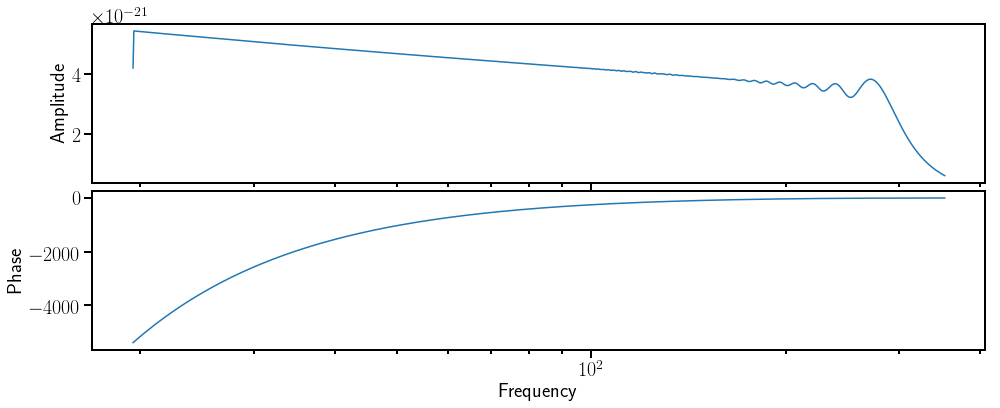

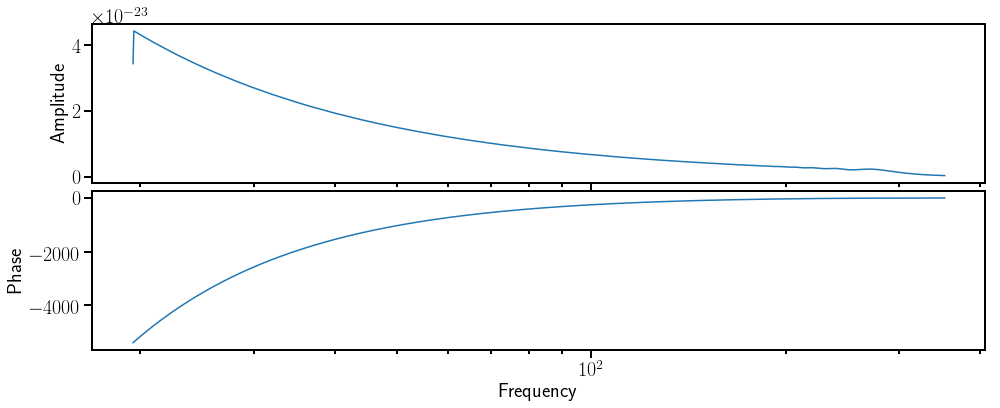

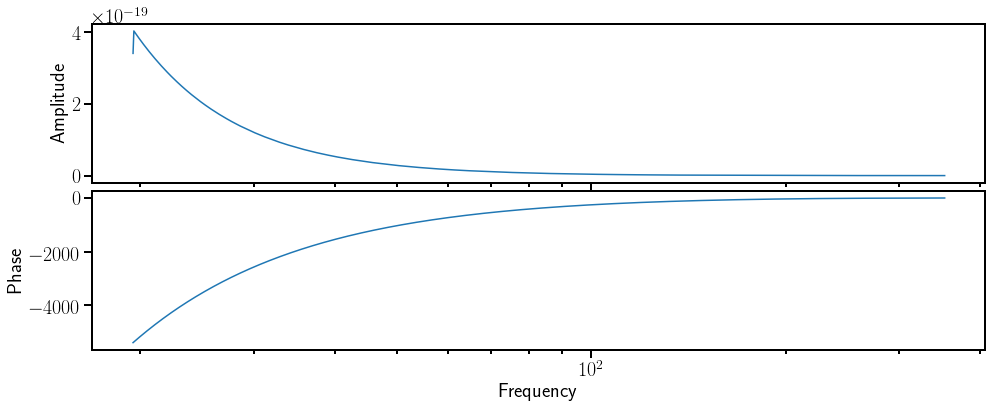

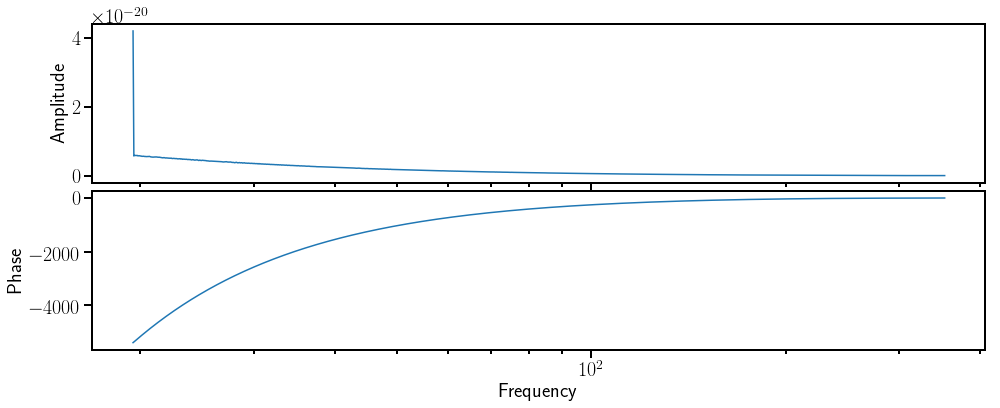

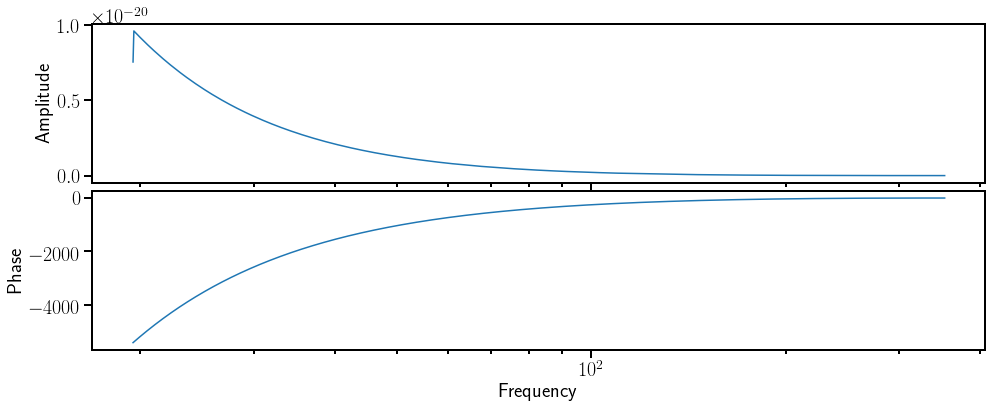

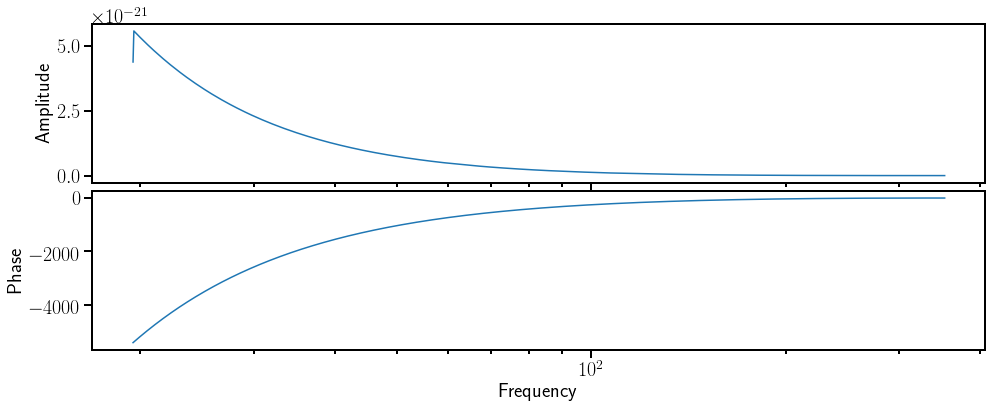

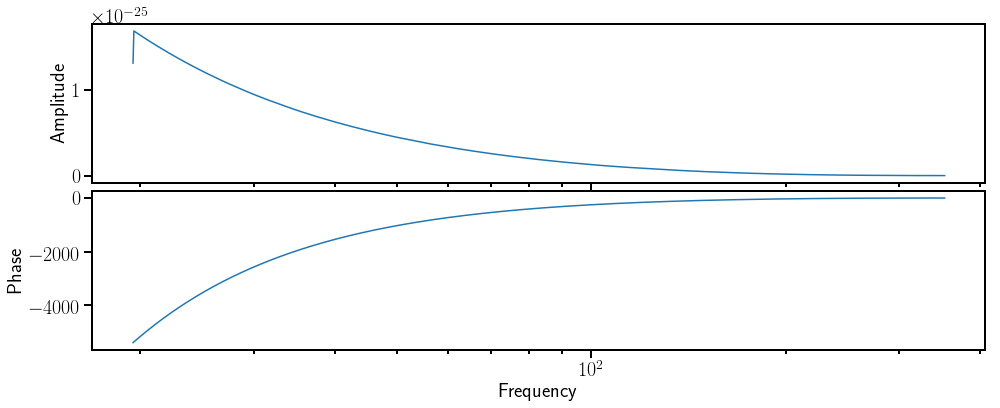

In [105]:
fig, (ax1, ax2) = wave.plot_waveforms_fd(fisher_sur.derivatives)

[wave.plot_waveforms_fd([fisher_sur.derivatives[i]]) for i in range(7)]
#ax1.set_yscale('log')
#wave.plot_waveform_difference_fd(fisher_f2.derivatives[1], dh_dphic, npoints=10000)

# Compare to original time domain TaylorT4 with physical units

In [ ]:
def lalsim

In [225]:
delta_t = 1.0/(2.0*f_max)
#delta_t = 1.0/2**12

f_minT4 = 30.0
hpT4, hcT4 = lalsim_waveform_time_series(
    approximant='SpinTaylorT4', 
    mass1=mass1, mass2=mass2, 
    spin1x=0, spin1y=0, spin1z=spin1z, 
    spin2x=0, spin2y=0, spin2z=spin2z, 
    lambda1=lambda1, lambda2=lambda2, 
    distance=distance, inclination=inclination, 
    delta_t=delta_t, f_min=f_minT4, f_ref=f_ref, 
    amplitude_order=0)

print hpT4.end_time, hpT4.sample_times[-1]
# Now extend the waveform so that delta_f will be small when you take the Fourier transform
# ...
ntime = (len(hp_true_phys) - 1)*2
hpT4.resize(ntime)

print hpT4.end_time, hpT4.sample_times[-1]

0.00012207 -3.75003139652e-10
64.435058593 64.4349365231


In [226]:
len(hp_true_phys), len(hpT4), np.array(hpT4)

(409600,
 819198,
 array([ -1.07198048e-25,  -4.30299157e-25,  -7.53173429e-25, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]))

In [227]:
hpT4tilde = hpT4.to_frequencyseries()
hpT4tilde.delta_f, hp_sur_phys.delta_f

(0.010000024414122104, 0.01)

In [228]:
len(hpT4tilde)

409600

In [229]:
float(hpT4tilde.epoch), hpT4.sample_times[0], hpT4.sample_times[-1], float(hpT4.end_time)

(-35.564697266, -35.564697266000003, 64.434936523062504, 64.435058593)

In [230]:
t_start = float(hpT4tilde.epoch)
t_coal = 0.0
dt_insp = t_coal - t_start
freqs = np.array(hpT4tilde.sample_frequencies)
newdata = np.array(hpT4tilde) * np.exp(2.0j*np.pi*freqs*dt_insp)

# Zero waveform below f_min
newdata[freqs<=f_min] = 0.0

In [231]:
freqs<=f_min, newdata

(array([ True,  True,  True, ..., False, False, False], dtype=bool),
 array([  0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j, ...,
         -7.15525504e-27 +3.08899732e-30j,
         -7.15650080e-27 -2.71567234e-30j,  -7.15113602e-27 -6.90158387e-32j]))

In [232]:
hpT4tilde = pycbc.types.FrequencySeries(newdata, delta_f=hpT4tilde.delta_f, epoch=hpT4tilde.epoch)

In [233]:
hp_t4 = wave.Waveform.from_hp_hc(
    np.array(hpT4tilde.sample_frequencies), np.array(hpT4tilde).real, np.array(hpT4tilde).imag)

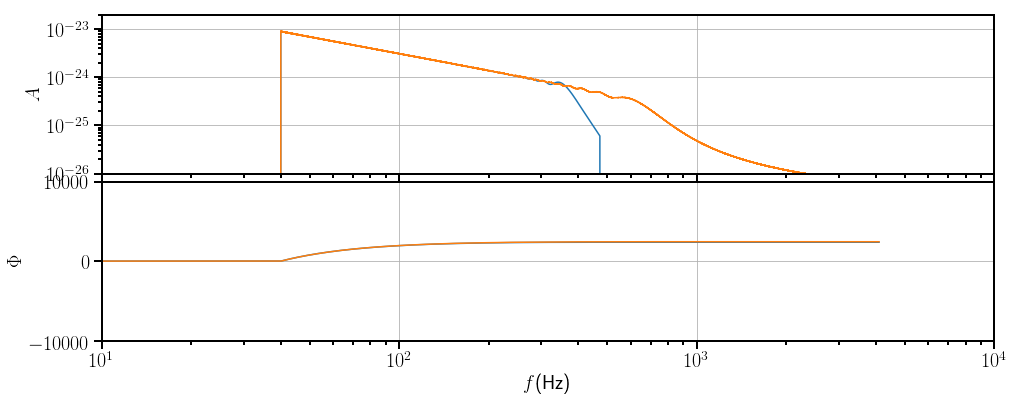

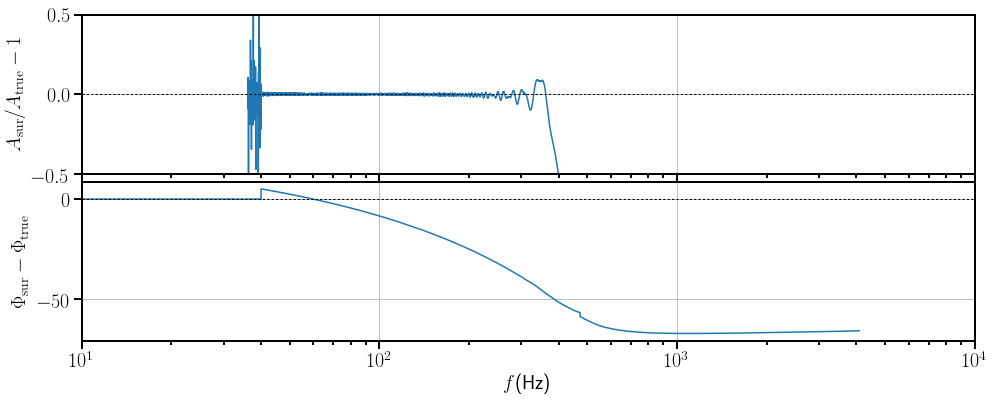

In [234]:
# Plot h_true and h_sur
fig, (ax1, ax2) = wave.plot_waveforms_fd([hp_sur, hp_t4])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$f$(Hz)')
ax1.set_ylim(1.0e-26, 2.0e-23)
ax2.set_xlim(10, 10000)
ax2.set_ylim(-10000, 10000)
ax1.grid()
ax2.grid()

# Plot error
fig, (ax1, ax2) = wave.plot_waveform_difference_fd(hp_sur, hp_t4, xi=10, npoints=10000)
ax1.set_ylabel(r'$A_{\rm sur}/A_{\rm true} - 1$')
ax2.set_ylabel(r'$\Phi_{\rm sur} - \Phi_{\rm true}$')
ax2.set_xlabel(r'$f$(Hz)')
ax1.set_ylim(-0.5, 0.5)
ax2.set_xlim(10, 10000)
ax1.grid()
ax2.grid()

In [235]:
len(hpT4tilde), len(hp_sur_phys), hpT4tilde.delta_f, hp_sur_phys.delta_f

(409600, 409600, 0.010000024414122104, 0.01)

In [238]:
# The delta_f of the T4 waveform is not quite the same as the surrogate. This will throw an error
hpT4tildenudged = pycbc.types.FrequencySeries(np.array(hpT4tilde), delta_f=hp_sur_phys.delta_f, epoch=hpT4tilde.epoch)
mismatch(hp_sur_phys, hpT4tildenudged, 40.0)

0.01


0.29037000635867527

In [ ]:
def inverse_fourier_transform_uniform_sampled_waveform(h):
    """Inverse Fourier transform a uniformly sampled waveform.
    If possible, pad the waveform so its length is a power of 2.
    """
    df = h.x[1]-h.x[0]
    npoints = len(h.x)

    # Put data in complex format
    data = h.amp * np.exp(1.0j*h.phase)

    # Do the Fourier transform
    data_tilde = dt*np.fft.fft(data)
    freqs = np.arange(npoints)/(npoints*dt)

    # Convert data to Waveform object
    return Waveform.from_complex(freqs, data_tilde)

In [223]:
hp_sur_time = hp_sur_phys.to_timeseries()
hc_sur_time = hc_sur_phys.to_timeseries()
sur_time = 

In [117]:
hp_sur_phys.epoch

LIGOTimeGPS(0, 0)

In [122]:
float(hp_sur_time.end_time), hp_sur_time.sample_times[-1]+hp_sur_time.delta_t

(100.0, 100.0)

In [113]:
np.array(hp_sur_time)

array([  2.90071328e-24,   2.80040971e-24,   2.26753187e-24, ...,
         5.69331472e-25,   1.72315971e-24,   2.53191787e-24])

(-0.2, 0.01)

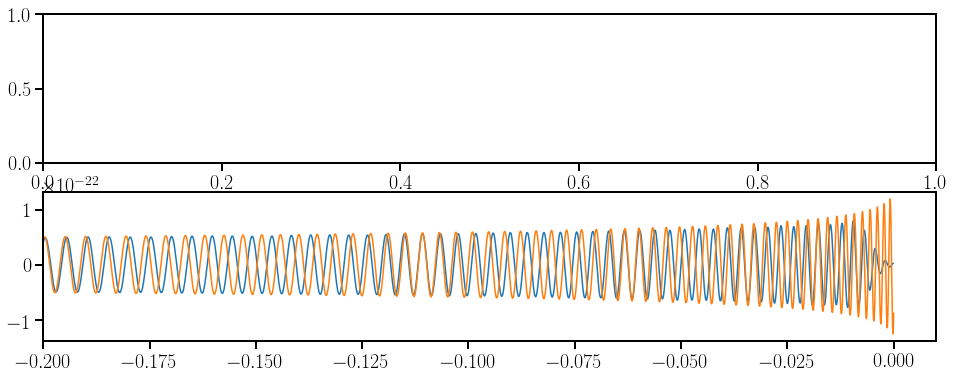

In [125]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
# ax1.plot(np.array(hp_sur_time.sample_times)-float(hp_sur_time.end_time), np.array(hp_sur_time))
# ax1.plot(np.array(hpT4.sample_times), np.array(hpT4))

ax2.plot(np.array(hp_sur_time.sample_times)-float(hp_sur_time.end_time), np.array(hp_sur_time))
ax2.plot(np.array(hpT4.sample_times), np.array(hpT4))
ax2.set_xlim(-0.200, 0.010)

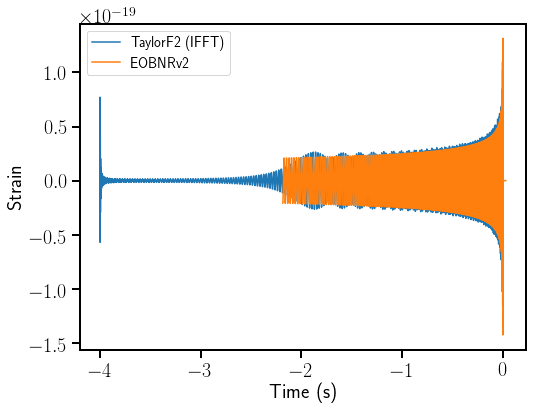

In [126]:
# Plot a time domain and fourier domain waveform together in the time domain.
# Note that without special cleanup the Fourier domain waveform will exhibit
# the Gibb's phenomenon. (http://en.wikipedia.org/wiki/Gibbs_phenomenon)

import pylab
from pycbc import types, fft, waveform

# Get a time domain waveform
hp, hc = waveform.get_td_waveform(approximant="EOBNRv2",
                             mass1=6, mass2=6, delta_t=1.0/4096, f_lower=40)

# Get a frequency domain waveform
sptilde, sctilde = waveform. get_fd_waveform(approximant="TaylorF2",
                             mass1=6, mass2=6, delta_f=1.0/4, f_lower=40)

# FFT it to the time-domain
tlen = int(1.0 / hp.delta_t / sptilde.delta_f)
sptilde.resize(tlen/2 + 1)
# Alocate memory for the IFFT'd waveform
sp = types.TimeSeries(types.zeros(tlen), delta_t=hp.delta_t)
fft.ifft(sptilde, sp)

pylab.plot(sp.sample_times, sp, label="TaylorF2 (IFFT)")
pylab.plot(hp.sample_times, hp, label="EOBNRv2")

pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.legend()

# Compare surrogate with TaylorF2 in physical units

In [18]:
mass1 = 3.0
mass2 = 1.4
spin1z = 0.0
spin2z = 0.0
lambda1 = 0.0
lambda2 = 0.0
delta_f = 1.0e-2
#f_min = 100.0
f_min = mf_to_f(0.001, mass1+mass2)
print f_min
f_max = 5000.0
distance = 100.0
inclination = 0.0

freq, hp, hc = surrogate_waveform_physical(Bamp_j, Bphase_j, damp_gp_list, dphase_gp_list, 
                                mass1=mass1, mass2=mass2, spin1z=spin1z, spin2z=spin2z, 
                                lambda1=lambda1, lambda2=lambda2,
                                delta_f=delta_f, f_min=f_min, f_max=f_max, f_ref=None, 
                                distance=distance, inclination=inclination, coa_phase=None)

freq_lal, hp_lal, hc_lal = lalsim_fd_waveform_arrays(mass1=mass1, mass2=mass2, spin1z=spin1z, spin2z=spin2z, 
                                spin1x=0, spin1y=0, spin2x=0, spin2y=0, 
                                lambda1=lambda1, lambda2=lambda2, 
                                delta_f=delta_f, f_min=f_min, f_max=f_max, f_ref=None, 
                                distance=distance, inclination=inclination, coa_phase=None, 
                                approximant='TaylorF2')

46.1421462539


NameError: name 'surrogate_waveform_physical' is not defined

In [36]:
hpwave = wave.Waveform.from_hp_hc(freq, hp.real, hp.imag)
hplalwave = wave.Waveform.from_hp_hc(freq_lal, hp_lal.real, hp_lal.imag)

hcwave = wave.Waveform.from_hp_hc(freq, hc.real, hc.imag)
hclalwave = wave.Waveform.from_hp_hc(freq_lal, hc_lal.real, hc_lal.imag)

hpwave.x.shape, hplalwave.x.shape

((500000,), (500001,))

(10, 10000)

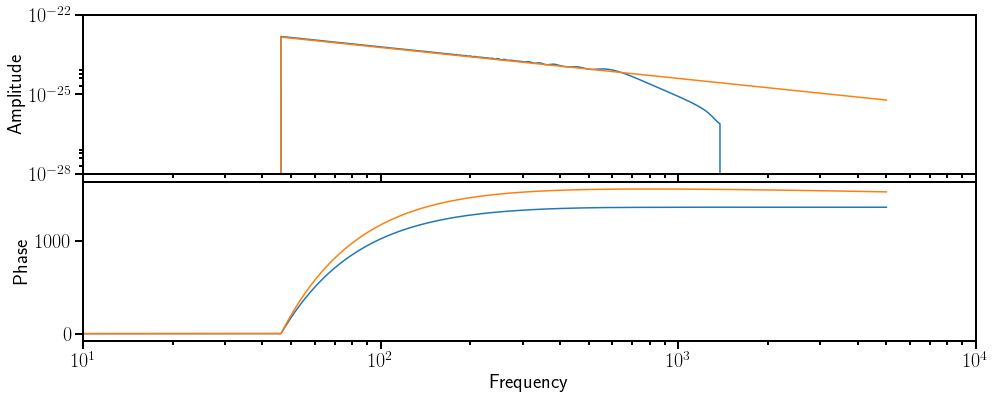

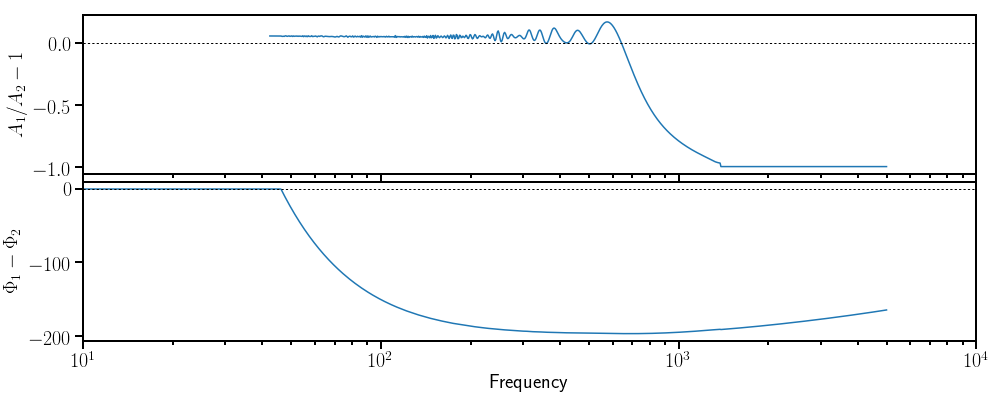

In [38]:
# Plot h_true and h_sur
fig, (ax1, ax2) = wave.plot_waveforms_fd([hpwave, hplalwave], xi=10)
ax1.set_yscale('log')
ax1.set_ylim(1.0e-28, 1.0e-22)
ax2.set_xlim(10, 10000)

fig, (ax1, ax2) = wave.plot_waveform_difference_fd(hpwave, hplalwave, xi=10.0)
ax2.set_xlim(10, 10000)

# Compare surrogate with SpinTaylorT4 in physical units

(100, 3000)

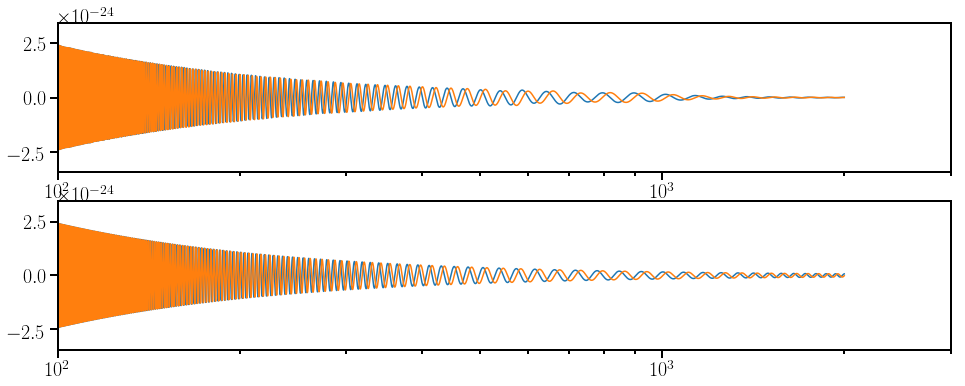

In [101]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
ax1.plot(freq, np.real(hp))
ax1.plot(freq, np.imag(hp))
ax1.set_xscale('log')

ax2.plot(freq_lal, np.real(hp_lal))
ax2.plot(freq_lal, np.imag(hp_lal))
ax2.set_xscale('log')

ax1.set_xlim(100, 3000)
ax2.set_xlim(100, 3000)

In [22]:
mass1 = 1.4
mass2 = 1.4
spin1z = 0.4
spin2z = 0.4 
lambda1 = 2000.0
lambda2 = 2000.0
delta_t = 1.0/2**12
f_min = 80.0
distance = 100.0
inclination = 1.2

hpT4, hcT4 = lalsim_waveform_time_series(approximant='SpinTaylorT4', 
                        mass1=mass1, mass2=mass2, 
                        spin1x=0, spin1y=0, spin1z=spin1z, 
                        spin2x=0, spin2y=0, spin2z=spin2z, 
                        lambda1=lambda1, lambda2=lambda2, 
                        distance=distance, inclination=inclination, 
                        delta_t=delta_t, f_min=f_min, f_ref=f_min, 
                        amplitude_order=-1)

# hp1T4, hc1T4 = pycbc.waveform.get_td_waveform(approximant='SpinTaylorT4', 
#                         mass1=mass1, mass2=mass2, 
#                         spin1z=spin1z, spin2z=spin2z, 
#                         lambda1=lambda1, lambda2=lambda2, 
#                         distance=distance, inclination=inclination, 
#                         delta_t=delta_t, f_lower=f_lower, f_ref=f_lower, 
#                         amplitude_order=-1)

In [23]:
htildeT4 = hpT4.to_frequencyseries()
freqs = np.array(htildeT4.sample_frequencies)

In [24]:
hpwave.resample(freqs, order=2)

In [28]:
hcomp = hpwave.amp*np.exp(1.0j*hpwave.phase)

In [29]:
hsurFS = pycbc.types.FrequencySeries(hcomp, delta_f=freqs[1]-freqs[0])

In [33]:
hsurFS.delta_f, htildeT4.delta_f, len(hsurFS)

(0.24656874548519142, 0.24656874548519142, 8308)

In [35]:
mismatch(hsurFS, htildeT4, 100.0)

0.57041595436380854

(200, 300)

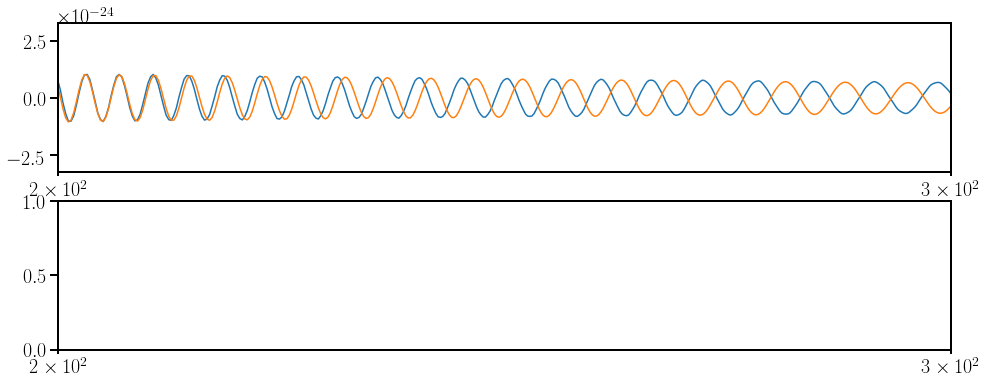

In [40]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
ax1.plot(htildeT4.sample_frequencies, np.real(htildeT4))
ax1.plot(hsurFS.sample_frequencies, np.real(hsurFS))
ax1.set_xscale('log')

# ax2.plot(freq_lal, np.real(hp_lal))
# ax2.plot(freq_lal, np.imag(hp_lal))
ax2.set_xscale('log')

ax1.set_xlim(200, 300)
ax2.set_xlim(200, 300)